In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Sequence
import numpy as np
from scipy import stats
import statsmodels.api as sm
import requests
import json

In [2]:
df = pd.read_excel("data/Project 1_2024.xlsx", sheet_name="Data", index_col="Date", parse_dates=["Date"])

In [3]:
# Пропущенных значений нет
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1543 entries, 2017-01-09 to 2021-03-31
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Income   1543 non-null   float64
 1   Outcome  1543 non-null   float64
 2   Balance  1543 non-null   float64
dtypes: float64(3)
memory usage: 48.2 KB


In [6]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
from plotly.subplots import make_subplots
init_notebook_mode(connected = True)

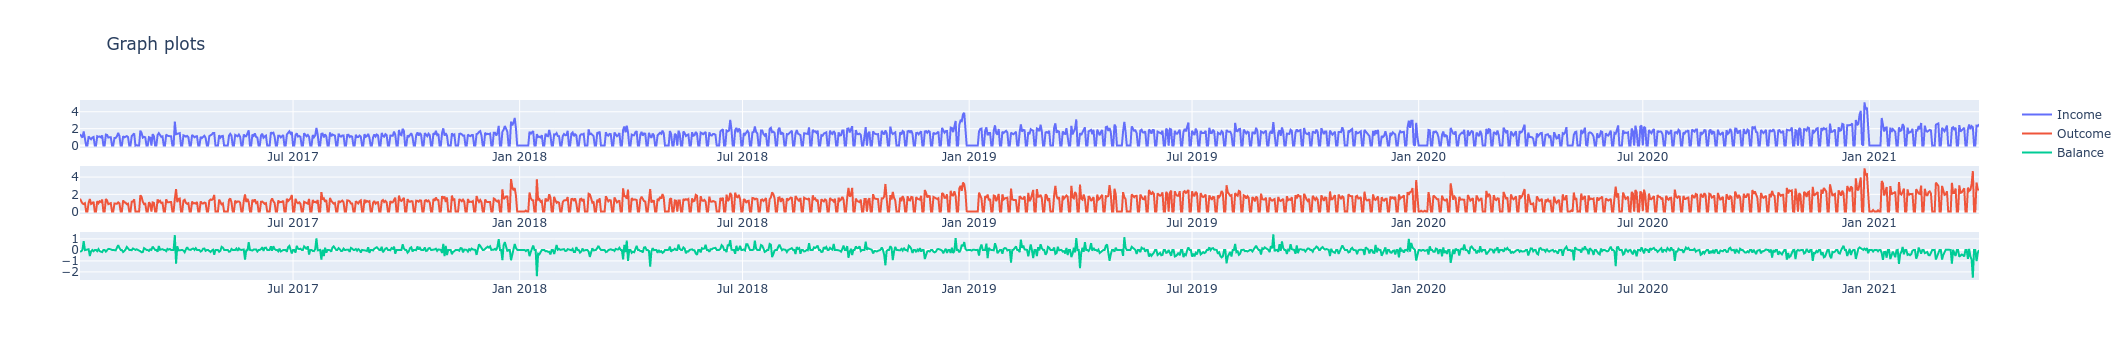

In [7]:
def plotly_df(df, title = ''):

    fig = make_subplots(rows=df.shape[1], cols=1)
    counter = 1
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        fig.add_trace(trace,
                      col=1,
                      row=counter)
        counter += 1

    layout = dict(title = title)
    fig.update_layout(layout)
    iplot(fig, show_link=False)



plotly_df(df, title = "Graph plots")

In [9]:
def weighted_average(series: Sequence, weights: Sequence):
    '''
    Calculates weighted cumulative sum for the series
    Note: weights MUST sum to 1
    '''
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

In [13]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

<Axes: xlabel='Date'>

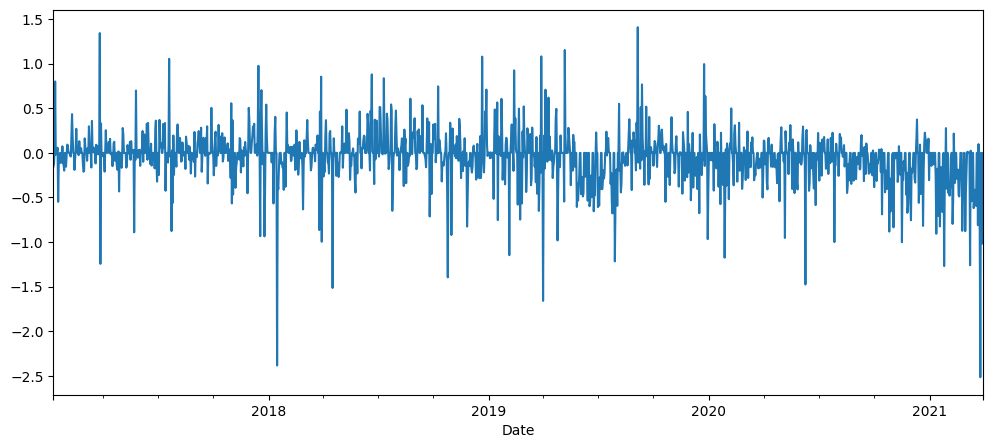

In [16]:
df["Balance"].plot(figsize = (12, 5))

<Axes: >

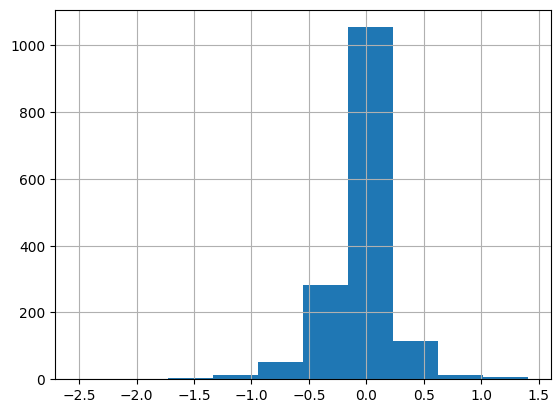

In [17]:
df["Balance"].hist()

In [18]:
df['weekend'] = np.where(df.index.weekday > 4, 1, 0)

In [19]:
df['day_of_week'] = df.index.weekday

In [20]:
day_of_week_columns = pd.get_dummies(df['day_of_week'], dtype=int)
day_of_week_columns.columns = ["Monday", "Tuesday", "Wednesday", "Thursday", "Firday", "Saturday", "Sunday"]

In [21]:
df = df.merge(day_of_week_columns, left_index=True, right_index=True)

In [22]:
df

,Income,Outcome,Balance,weekend,day_of_week,Monday,Tuesday,Wednesday,Thursday,Firday,Saturday,Sunday
Date,,,,,,,,,,,,
2017-01-09,1.343028,1.487865,-0.155904,0,0,1,0,0,0,0,0,0
2017-01-10,1.068610,1.194182,-0.125572,0,1,0,1,0,0,0,0,0
2017-01-11,0.944429,0.936663,0.007767,0,2,0,0,1,0,0,0,0
2017-01-12,1.672202,0.875379,0.800391,0,3,0,0,0,1,0,0,0
2017-01-13,0.955924,0.975645,-0.019721,0,4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,0.000000,0.000000,0.000000,1,5,0,0,0,0,0,1,0
2021-03-28,0.000000,0.000000,0.000000,1,6,0,0,0,0,0,0,1
2021-03-29,2.356883,3.370738,-1.017679,0,0,1,0,0,0,0,0,0


Another approach to encoding day of week information

In [24]:
df['day_of_week_sin'] = np.sin(df['day_of_week'] * (2 * np.pi / 7))
df['day_of_week_cos'] = np.cos(df['day_of_week'] * (2 * np.pi / 7))

In [25]:
calendar = requests.get("https://raw.githubusercontent.com/d10xa/holidays-calendar/master/json/calendar.json")

In [26]:
calendar = json.loads(calendar.text)

In [27]:
calendar.keys()

dict_keys(['holidays', 'preholidays', 'nowork'])

In [28]:
calendar = {k: pd.to_datetime(v) for k, v in calendar.items()}

In [29]:
df["holiday"] = df.index.isin(calendar["holidays"].union(calendar["nowork"])).astype(int)

In [30]:
df["preholiday"] = df.index.isin(calendar["preholidays"]).astype(int)

In [31]:
month=pd.get_dummies(df.index.month,prefix='month', dtype=int).set_index(df.index)
month.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Date,,,,,,,,,,,,
2017-01-09,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-10,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-11,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-12,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-13,1,0,0,0,0,0,0,0,0,0,0,0


In [32]:
quarter=pd.get_dummies(df.index.quarter,prefix='quarter', dtype=int).set_index(df.index)
quarter.head()

,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,
2017-01-09,1,0,0,0
2017-01-10,1,0,0,0
2017-01-11,1,0,0,0
2017-01-12,1,0,0,0
2017-01-13,1,0,0,0


Соберем наши календарные признаки в один датафрейм - наше общее признаковое пространство.

In [33]:
df=pd.concat([df, month,quarter],axis=1)

Добавим ключевую ставку

In [34]:
keyrate = pd.read_csv("data/keyrate.csv", index_col="date", parse_dates=["date"])

In [35]:
keyrate.columns = ["keyrate"]

In [36]:
df = df.join(keyrate, on=df.index, )

In [37]:
# fill na values

df["keyrate"] = df["keyrate"].bfill()

In [38]:
def set_payday(df):
    # Initialize target feature column
    df['payday'] = 0
    
    # Iterate over each row in the DataFrame
    for index, data in df.iterrows():
        if index.day in [15, 25, 28]:
            # Check if weekend, holiday, and target feature are all zero
            if data['weekend'] == 0 and data['holiday'] == 0:
                data['payday'] = 1
            else:
                loc = df.index.get_loc(index)
                # If any of weekend, holiday, or target feature is 1, find the upper row where all are zero
                upper_row_index = loc + 1
                loc = df.index[upper_row_index]
                while upper_row_index < len(df) and (df.loc[loc, 'weekend'] == 1 or df.loc[loc, 'holiday'] == 1):
                    upper_row_index += 1
                    loc = df.index[upper_row_index]
                df.at[loc, "payday"] = 1

    return df

In [39]:
df = set_payday(df)

### Add statistical and lag features

In [40]:
rolling_weekly = df["Balance"].rolling(7).agg(['mean','std','median','max','min'])
rolling_weekly = rolling_weekly.add_suffix("_weekly")

In [41]:
rolling_monthly = df["Balance"].rolling(30).agg(['mean','std','median','max','min'])
rolling_monthly = rolling_monthly.add_suffix("_monthly")

In [42]:
# we lose first 30 rows as we do this
df = df.join(rolling_weekly)
df = df.join(rolling_monthly)

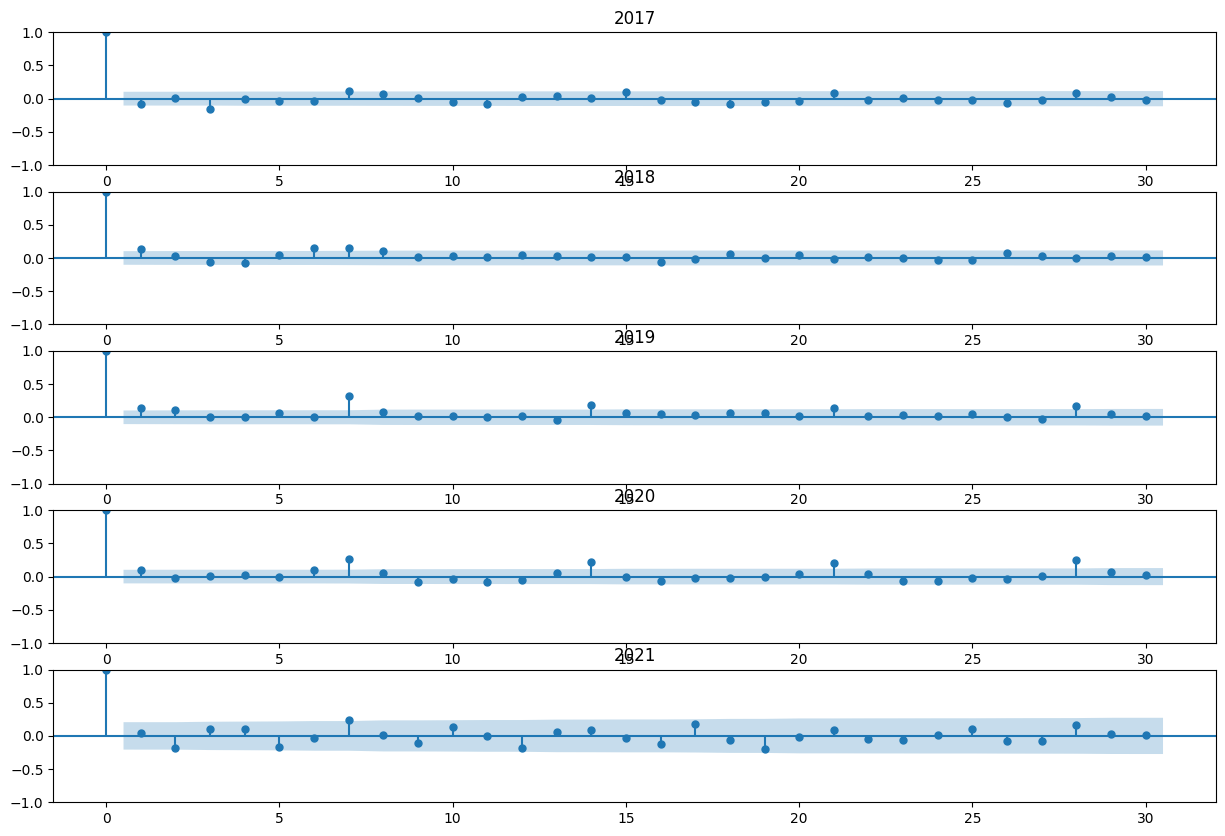

In [43]:
# autocorrelation
years = df.index.year.unique().tolist()

fig, axs = plt.subplots(len(years))
fig.figure.set_figwidth(15)
fig.figure.set_figheight(10)
for i in range(len(years)):
    sm.graphics.tsa.plot_acf(df[df.index.year == years[i]].Balance.values.squeeze(), lags=30, ax=axs[i])
    axs[i].set_title(years[i])

plt.show()

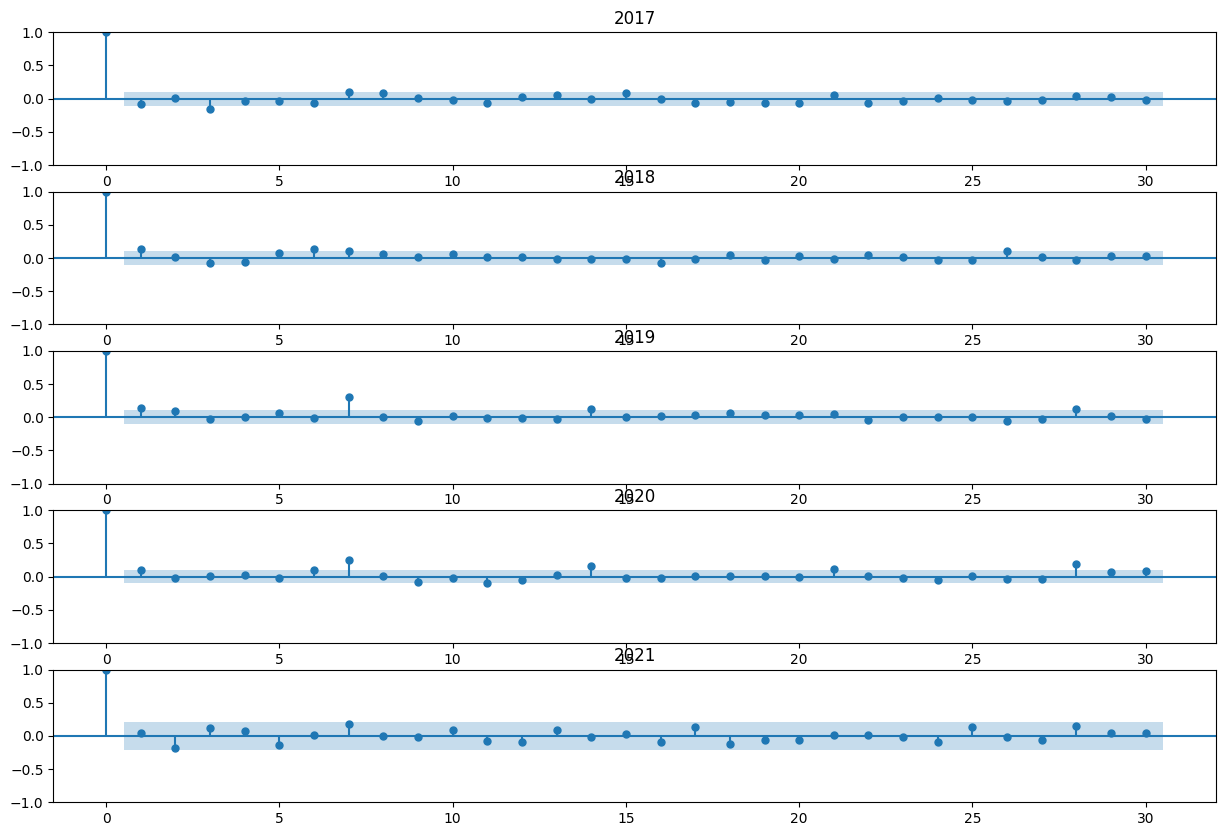

In [44]:
# partial autocorrelation

fig, axs = plt.subplots(len(years))
fig.figure.set_figwidth(15)
fig.figure.set_figheight(10)
for i in range(len(years)):
    sm.graphics.tsa.plot_pacf(df[df.index.year == years[i]].Balance.values.squeeze(), lags=30, ax=axs[i])
    axs[i].set_title(years[i])

plt.show()

### Судя по графикам, лаги нам дадут мало -- хотя и по самому временному ряду видна была скорее сезонность и отсутствие тренда.

Так что придется поработать скорее с сезонностью и внешними фичами

Докинем пару лагов просто для отбора фичей и тестирования в дальнейшем, хотя сейчас выглядит скорее бесперспективно

In [45]:
df["first_lag"] = df.Balance.shift(1)
df["second_lag"] = df.Balance.shift(2)

In [46]:
# убираем получившиеся в результате взятия скользящего среднего и лагов NA values
df = df.dropna()

In [47]:
pd.set_option('display.max_columns',None)

In [48]:
df

,key_0,Income,Outcome,Balance,weekend,day_of_week,Monday,Tuesday,Wednesday,Thursday,Firday,Saturday,Sunday,day_of_week_sin,day_of_week_cos,holiday,preholiday,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4,keyrate,payday,mean_weekly,std_weekly,median_weekly,max_weekly,min_weekly,mean_monthly,std_monthly,median_monthly,max_monthly,min_monthly,first_lag,second_lag
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-02-07,2017-02-07,0.911931,0.953220,-0.041289,0,1,0,1,0,0,0,0,0,0.781831,0.623490,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,10.0,0,0.015692,0.052785,0.000000,0.093309,-0.041289,-0.026060,0.196902,-0.002695,0.800391,-0.548519,-0.032282,0.000000
2017-02-08,2017-02-08,1.102422,0.905478,0.196944,0,2,0,0,1,0,0,0,0,0.974928,-0.222521,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,10.0,0,0.030497,0.083677,0.000000,0.196944,-0.041289,-0.014298,0.199401,0.000000,0.800391,-0.548519,-0.041289,-0.032282
2017-02-09,2017-02-09,1.501032,1.071717,0.434681,0,3,0,0,0,1,0,0,0,0.433884,-0.900969,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,10.0,0,0.080692,0.175570,0.000000,0.434681,-0.041289,0.004377,0.214299,0.000000,0.800391,-0.548519,0.196944,-0.041289
2017-02-10,2017-02-10,1.147702,0.964149,0.183553,0,4,0,0,0,0,1,0,0,-0.433884,-0.900969,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,10.0,0,0.105944,0.175881,0.000000,0.434681,-0.041289,0.010236,0.216784,0.000000,0.800391,-0.548519,0.434681,0.196944
2017-02-11,2017-02-11,0.000000,0.000000,0.000000,1,5,0,0,0,0,0,1,0,-0.974928,-0.222521,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,10.0,0,0.105944,0.175881,0.000000,0.434681,-0.041289,-0.016443,0.157269,0.000000,0.434681,-0.548519,0.183553,0.434681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,2021-03-27,0.000000,0.000000,0.000000,1,5,0,0,0,0,0,1,0,-0.974928,-0.222521,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,4.5,0,-0.669331,0.909013,-0.587778,0.098041,-2.514887,-0.376162,0.537440,-0.275088,0.098041,-2.514887,-2.514887,-0.869810
2021-03-28,2021-03-28,0.000000,0.000000,0.000000,1,6,0,0,0,0,0,0,1,-0.781831,0.623490,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,4.5,0,-0.669331,0.909013,-0.587778,0.098041,-2.514887,-0.364302,0.541813,-0.115991,0.098041,-2.514887,0.000000,-2.514887
2021-03-29,2021-03-29,2.356883,3.370738,-1.017679,0,0,1,0,0,0,0,0,0,0.000000,1.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,4.5,1,-0.698873,0.917698,-0.587778,0.098041,-2.514887,-0.398224,0.550013,-0.275088,0.098041,-2.514887,0.000000,0.000000


In [49]:
df.drop(columns=["day_of_week"], inplace=True)

In [50]:
df.to_csv("data/featurized_dataset.csv", index_label="date")